# Modeling data from an industrial dryer (Cambridge Control Ltd)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Proyecto_Splra')

Mounted at /content/drive


In [2]:
cd SIPPY-master/

/content/drive/MyDrive/Proyecto_Splra/SIPPY-master


In [3]:
!pip install scikit-build
!pip install setuptools_scm
!pip install control -U
!pip install scienceplots
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 812.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 694.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 5.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base 

In [4]:
!python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as la
from sklearn import preprocessing
import time
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/content/drive/MyDrive/Proyecto_Splra/Python")

from Sparse_Sys_Id import*
from Lra_Modeling import *

from sklearn.metrics import r2_score
mpl.rcParams['lines.linewidth'] = 0.6

In [6]:
data= np.loadtxt( '/content/drive/MyDrive/Proyecto_Splra/Data/dryer2.dat' )
data.shape

(867, 7)

In [7]:
X = data[:,1:]
#X = signal.detrend(X.T).T
#X = X-X[0:1,:]
X.shape

(867, 6)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_stand = scaler.transform(X)

In [9]:
dfX = pd.DataFrame(X_stand, columns=['U1','U2','U3','Y1','Y2','Y3'])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

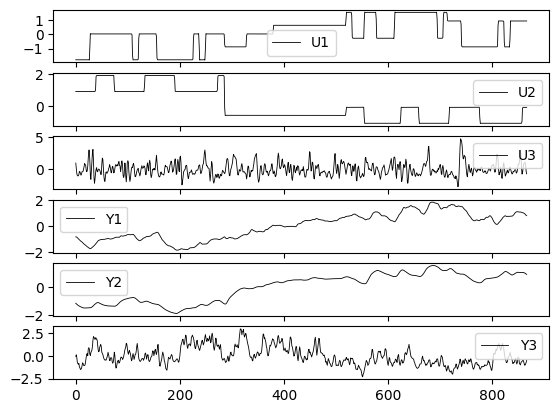

In [10]:
dfX.plot(subplots=True,color='k')

In [11]:
ntest=int(0.50*len(dfX))

wtrain,wtest=dfX[:-ntest],dfX[-ntest:]

## Sp_lra Modeling

In [12]:
L=1

In [13]:
from Sparse_Lra import *

In [14]:
M,fit,wh,R_sp,sys_tf,sys_ss,x0 = Sparse_lra_sysid(wtrain.values.T,L,3,tol=0.5,delta=0.001)

In [15]:
M,fit

(16.587470175562967, 61.846114238942775)

In [16]:
Xdf_id = pd.DataFrame(wh.T, columns=['U1id','U2id','U3id','Y1id','Y2id','Y3id'])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

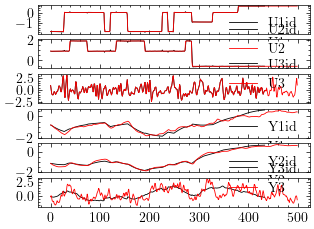

In [17]:
ax=Xdf_id[:500].plot(subplots=True,color='k')
dfX[:500].plot(ax=ax,subplots=True,color='r')

In [18]:
t,y=ctl.forced_response(sys_ss,U=dfX.values[:,:-3].T,X0=x0)

In [19]:
wh_test=np.block([[dfX.values[-ntest:,:-3].T],[y[:,-ntest:]]])

In [20]:
1-(la.norm(wtest.values.T-wh_test)/la.norm(wtest.values-np.mean(wtest.values)))

0.5336638402217013

In [21]:
sparsity_ss(sys_ss)

75.0

In [22]:
from sippy import *
from sippy import functionset as fset
import control.matlab as cnt
from sippy import functionsetSIM as fsetSIM

In [23]:
sys_sippy = system_identification(wtrain.values[:,-3:], wtrain.values[:,:-3], 'MOESP', IC='AIC')

The suggested order is: n= 3


In [24]:
sys_sippy_ss = ctl.ss(sys_sippy.A, sys_sippy.B, sys_sippy.C, sys_sippy.D,1)

In [25]:
x0_ls=x0_ss_estimate(sys_sippy_ss ,2,wtrain.values[:,-3:].T, wtrain.values[:,:-3].T)
t,y=ctl.forced_response(sys_sippy_ss ,U=dfX.values[:,:-3].T,X0=x0_ls)

In [26]:
y.shape

(3, 867)

In [27]:
1-(la.norm(wtrain.values.T[-3:,:]-y[:,:-ntest])/la.norm(wtrain.values.T[-3:,:]-np.mean(wtrain.values.T[-3:,:])))

0.5832466244725247

In [28]:
1-(la.norm(wtest.values.T[-3:,:]-y[:,-ntest:])/la.norm(wtest.values.T[-3:,:]-np.mean(wtest.values.T[-3:,:])))

0.3597730301269503

In [29]:
sparsity_ss(sys_sippy_ss)

75.0